In [1]:
import os
import pickle
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from textwrap import wrap
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import cozie_functions


In [9]:
# add data folder to path
data_path = os.path.abspath(os.path.join(os.path.dirname( "__file__" ), '..', 'data'))
feature_set_df = pd.read_csv(os.path.join(data_path, '2019-11-15_cozie_full_masked.csv'))

# print(feature_set_df.columns)

# The following participants took part in the experiment:
participant_ids = ['cresh' + str(id).zfill(2) for id in range(1,31)] # from 1 to 30

# Drop User's that were trialing and not in the experiment
feature_set_df = feature_set_df[feature_set_df.user_id.isin(participant_ids)]

# only SDE4 votes
feature_set_df = feature_set_df[feature_set_df['room'].notnull()]
feature_set_df = feature_set_df[feature_set_df['room'] != 4]

print(feature_set_df['room'].unique()) # 1497, 25
print(feature_set_df.shape)
print("samples per participant: \n {}".format(feature_set_df.groupby(['user_id'], sort=False).size()))


[ 6.  1.  3.  2.  0.  7.  8.  9. 10. 11. 12. 13.  5. 14. 15. 16.]
(1497, 25)
samples per participant: 
 user_id
cresh08    44
cresh07    46
cresh09    49
cresh12    46
cresh10    45
cresh13    60
cresh14    99
cresh03    51
cresh15    49
cresh01    56
cresh06    46
cresh11    39
cresh05    50
cresh04    47
cresh02    65
cresh22    40
cresh21    52
cresh26    46
cresh29    55
cresh27    44
cresh19    39
cresh18    65
cresh23    47
cresh16    68
cresh30    42
cresh24    46
cresh17    43
cresh20    36
cresh28    46
cresh25    36
dtype: int64


In [10]:
palette = sns.color_palette("coolwarm", 3)

# custom read and blue from https://coolors.co/984447-add9f4-476c9b-468c98-101419 
# and grey from coolwarm palette
palette = ["#984447", palette[1], "#476c9b"]

# from https://imagecolorpicker.com/en/
palette_thermal = ["#a04c46", "#c0bfbf","#8099ba"]
palette_visual = ["#b78450", "#c0bfbf", "#a68ca6"]
# palette_aural = ["#a34275", "#c0bfbf", "#789966"]
palette_aural = ["#c0bfbf", "#789966"]

heatmap_args_nolim = dict(annot=False,
                          fmt="d", 
                          square=True, 
                          cmap=palette, 
                          lw=.5, 
                          cbar=False)


In [11]:
columns_needed = ['user_id', 'light_cozie', 'noise_cozie', 'thermal_cozie']
df_filtered = feature_set_df[feature_set_df.columns & columns_needed] # original size: 4378

df_filtered_clean = df_filtered.dropna()
print(df_filtered_clean.shape)

#1421, 4


(1421, 4)


# K-means clustering

In [12]:
### From: PublicationsPlots_v1.ipynb

# Drop Unecessary Columns
feature_set_df.drop(['Unnamed: 0', 'index', 'comfort_cozie', 'Space_id', 'Longitude',
                     'Latitude', 'co2_sensing', 'voc_sensing', 'Floor', 'lat_cozie', 
                     'lon_cozie', 'responseSpeed_cozie'], axis=1, inplace=True)

# Drop Mbient Data (Tier 1b)
feature_set_df.drop(["temperature_mbient"], axis=1, inplace=True)

# Drop Sensing Data (Tier 3)
feature_set_df.drop(["noise_sensing",
                    "temperature_sensing", "humidity_sensing", "light_sensing"], axis=1, inplace=True)

# Drop data where room was not localised. And Na's exist in data
feature_set_df.dropna(subset=['thermal_cozie', 'noise_cozie', 'light_cozie','heartRate_cozie', "room"], inplace=True)

# Group by preference and normalise the data. See cozie_functions.py
grouped_cozie_df = cozie_functions.normalise_total_cozie(feature_set_df, 'user_id', 10)

# Drop columns that are note required
grouped_cozie_df.drop(["thermal_cozie", "heartRate_cozie", "clothing",
                      "time", "room", "noise_cozie", "light_cozie", ], axis=1, inplace=True)

# Drop comfort values as these are redundant as (thremal_comfy = not prefer warm & prefer cool)
grouped_cozie_df.drop(["thermaly_comfy", 'aurally_comfy', 
                       'visually_comfy'], axis=1, inplace=True)

print(feature_set_df.shape) # (1407, 8)
print(grouped_cozie_df.shape) # (30, 6)
grouped_cozie_df.head()


(1407, 8)
(30, 6)


,prefer_cooler,prefer_warmer,prefer_dimmer,prefer_brighter,prefer_quieter,prefer_louder
user_id,,,,,,
cresh01,0.078431,0.156863,0.058824,0.313725,0.098039,0.0
cresh02,0.722222,0.111111,0.370370,0.222222,0.333333,0.0
cresh03,0.181818,0.045455,0.522727,0.159091,0.045455,0.0
cresh04,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
cresh05,0.280000,0.040000,0.040000,0.060000,0.000000,0.0


In [13]:
cluster_all = False

## Cluster with all features

In [14]:
def fit_clusters(df, num_clusters, column_name):
    k_means_cozie = KMeans(n_clusters=num_clusters, random_state=13).fit(df)
    centroids_cozie = k_means_cozie.cluster_centers_
    print(k_means_cozie.labels_)

    df[column_name] = k_means_cozie.labels_
    df.sort_values(by=[column_name], inplace=True)

    print(df.columns)
    clustermap = plt.figure()
    sns.heatmap(df.set_index(column_name), cmap="Blues")
    
    return df


In [15]:
if cluster_all:
    # fit clusters    
    grouped_cozie_df = fit_clusters(grouped_cozie_df, 9, 'user_cluster')
    grouped_cozie_df.head()

## Cluster with only the features of each type of response

[2 1 2 2 2 0 2 2 1 2 1 1 1 2 1 2 1 2 2 0 1 0 2 2 0 2 2 1 2 2]
Index(['prefer_cooler', 'prefer_warmer', 'thermal_cluster'], dtype='object')
[1 2 2 0 0 0 0 0 0 0 2 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0]
Index(['prefer_dimmer', 'prefer_brighter', 'light_cluster'], dtype='object')
[0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
Index(['prefer_cooler', 'prefer_warmer', 'prefer_quieter', 'prefer_louder',
       'aural_cluster'],
      dtype='object')


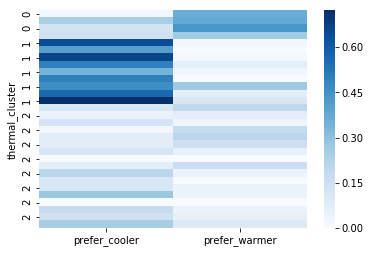

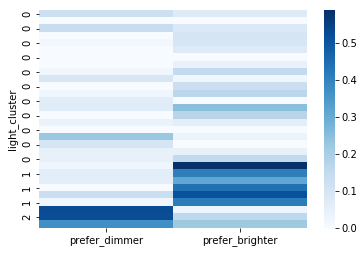

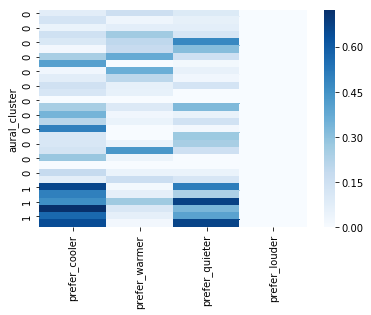

In [16]:
if not cluster_all:
    # copy a df for each type of response
    grouped_cozie_df_thermal = grouped_cozie_df.copy()
    grouped_cozie_df_thermal.drop(['prefer_dimmer', 'prefer_brighter', 'prefer_quieter', 'prefer_louder'], axis=1, inplace=True)

    grouped_cozie_df_light = grouped_cozie_df.copy()
    grouped_cozie_df_light.drop(['prefer_cooler', 'prefer_warmer', 'prefer_quieter', 'prefer_louder'], axis=1, inplace=True)
    
    grouped_cozie_df_aural = grouped_cozie_df.copy()    
    grouped_cozie_df_aural.drop(['prefer_dimmer', 'prefer_brighter', 'prefer_dimmer', 'prefer_brighter'], axis=1, inplace=True)
    
    # fit clusters
    grouped_cozie_df_thermal = fit_clusters(grouped_cozie_df_thermal, 3, 'thermal_cluster')
    grouped_cozie_df_light = fit_clusters(grouped_cozie_df_light, 3, 'light_cluster')
    grouped_cozie_df_aural = fit_clusters(grouped_cozie_df_aural, 2, 'aural_cluster')
    

# Dataframe with time-series and cluster information

In [17]:
if cluster_all:
    # left join on user_id and clusters
    df_clustered = pd.merge(df_filtered_clean, grouped_cozie_df, on=['user_id'])
    print(df_clustered.head())

    for cluster in df_clustered['user_cluster'].unique():
        curr_cluster = df_clustered[df_clustered['user_cluster'] == cluster]
        print(cluster)
        print(curr_cluster[['prefer_cooler', 'prefer_warmer']].max(axis=0))
    #     print(curr_cluster[['prefer_cooler', 'prefer_warmer']].idxmax(axis=0))

        print(curr_cluster[['prefer_dimmer', 'prefer_brighter']].max(axis=0))
    #     print(curr_cluster[['prefer_dimmer', 'prefer_brighter']].idxmax(axis=0))

        print(curr_cluster[['prefer_quieter', 'prefer_louder']].max(axis=0))
    #     print(curr_cluster[['prefer_quieter', 'prefer_louder']].idxmax(axis=0))

        print(curr_cluster['user_id'].unique())
        print("-")


In [18]:
if not cluster_all:
    # left join on user_id and clusters
    df_clustered = pd.merge(df_filtered_clean, grouped_cozie_df_thermal, on=['user_id'])
    df_clustered = pd.merge(df_clustered, grouped_cozie_df_light, on=['user_id'])
    df_clustered = pd.merge(df_clustered, grouped_cozie_df_aural, on=['user_id'])
    print(df_clustered.head())

   light_cozie  noise_cozie  thermal_cozie  user_id  prefer_cooler_x  \
0         10.0         10.0           10.0  cresh08         0.113636   
1         10.0         10.0           10.0  cresh08         0.113636   
2         10.0         11.0           10.0  cresh08         0.113636   
3         10.0         11.0           11.0  cresh08         0.113636   
4         10.0         11.0           10.0  cresh08         0.113636   

   prefer_warmer_x  thermal_cluster  prefer_dimmer  prefer_brighter  \
0              0.0                2       0.068182              0.0   
1              0.0                2       0.068182              0.0   
2              0.0                2       0.068182              0.0   
3              0.0                2       0.068182              0.0   
4              0.0                2       0.068182              0.0   

   light_cluster  prefer_cooler_y  prefer_warmer_y  prefer_quieter  \
0              0         0.113636              0.0        0.272727   


In [19]:
# from Figure 4: number of small clusters for the groups

# prefer cooler big cluster: 5
# prefer warmer big cluster: 1
# no preference big cluster: 3

# prefer dimmer big cluster: 2
# prefer brighter big cluster: 3
# no preference big cluster: 4

# prefer quieter big cluster: 5
# no preference big cluster: 4


# Merging clusters into 3 bigger ones

Cluster mapping, the columns are the values for the `prefer_cooler`, `prefer_dimmer`, and `prefer_quieter` for each type of comfort for the rows with the same names, and the `no_preference` rows too.
The `prefer_warmer`, and `prefer_brighter` values in the columns are used in the rows with the same name.

The values might differ slightly with the kmeans running (even with the same `rand_state` ?! but it remains somewhat consistent.

| Feedback        |          |          |          |          |          |
|-----------------|----------|----------|----------|----------|----------|
| prefer cooler   | 0.694915 | 0.404762 | 0.645161 | 0.557692 | 0.341463 |
| prefer warmer   | 0.439716 |          |          |          |          |
| no preference   | 0.153846 | 0.264151 | 0.288462 |          |          |
|-----------------|----------|----------|----------|----------|----------|
| prefer dimmer   | 0.511111 | 0.355932 |          |          |          |
| prefer brighter | 0.387755 | 0.476190 | 0.512821 |          |          |
| no preference   | 0.019231 | 0.102041 | 0.142857 | 0.205882 |          |
|-----------------|----------|----------|----------|----------|----------|
| prefer quieter  | 0.686275 | 0.642857 | 0.387097 | 0.309524 | 0.44898  |
| no preference   | 0.142857 | 0.129032 | 0.04878  | 0.211538 |          |


In [20]:
def merge_clusters(row, comfort='thermal'):
    if comfort == 'thermal':
        if row['prefer_cooler'] >= 0.33:
            return 11
        if row['prefer_warmer'] >= 0.3:
            return 9
        else:
            return 10
    elif comfort == 'visual':
        if row['prefer_dimmer'] >= 0.3:
            return 11
        if row['prefer_brighter'] > 0.35:
            return 9
        else:
            return 10
    elif comfort == 'aural':
        if row['prefer_quieter'] >= 0.3:
            return 11
        else:
            return 10


In [21]:
df_merged_clusters = df_clustered.copy()

if cluster_all:
    df_merged_clusters['big_cluster-thermal'] = df_merged_clusters.apply(lambda row: merge_clusters(row, 'thermal'), axis=1)
    df_merged_clusters['big_cluster-visual'] = df_merged_clusters.apply(lambda row: merge_clusters(row, 'visual'), axis=1)
    df_merged_clusters['big_cluster-aural'] = df_merged_clusters.apply(lambda row: merge_clusters(row, 'aural'), axis=1)

    print(df_merged_clusters['big_cluster-thermal'].unique())
    print(df_merged_clusters['big_cluster-visual'].unique())
    print(df_merged_clusters['big_cluster-aural'].unique())
    df_merged_clusters.head()
    

# Heatmap time-series

In [22]:
def plot_heatmap_tiles(df, ax, comfort='thermal', series_limit=75):
    """
    Plot time-series values of a given comfort with colored tiles
    """
    df_limit = pd.DataFrame(columns=df.columns)

    # limit the datapoints for each user
    for user in df['user_id'].unique():
        curr_user = df[df['user_id'] == user].reset_index(drop=True)
        df_limit = df_limit.append(curr_user.iloc[:series_limit, :])
    
    df_aux = pd.DataFrame(columns = ['datapoint', 'comfort', 'value'])
    
    # tranforms to heatmap-ready dataframe
    for index, row in df_limit.iterrows():
        if comfort == 'visual':
            new_row = {'datapoint':index, 'comfort':row.index[0] + "-" + row[3] , 'value':row[0]}
            df_aux = df_aux.append(new_row, ignore_index=True)
        elif comfort == 'aural':
            new_row = {'datapoint':index, 'comfort':row.index[1] + "-" + row[3] , 'value':row[1]}
            df_aux = df_aux.append(new_row, ignore_index=True)
        elif comfort == 'thermal':
            new_row = {'datapoint':index, 'comfort':row.index[2] + "-" + row[3] , 'value':row[2]}
            df_aux = df_aux.append(new_row, ignore_index=True)
            
    # plot heatmap
    if comfort == 'thermal':
        palette = palette_thermal
    elif comfort == 'visual':
        palette = palette_visual
    elif comfort == 'aural':
        palette = palette_aural

    heatmap_args_nolim_sq = heatmap_args_nolim.copy()
    heatmap_args_nolim_sq['cmap']=palette

    df_aux = df_aux.pivot("comfort", "datapoint", "value")

    sns.heatmap(df_aux, ax=ax, **heatmap_args_nolim_sq)
    
    ax.set_frame_on(True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')


## Thermal series

0
2
1


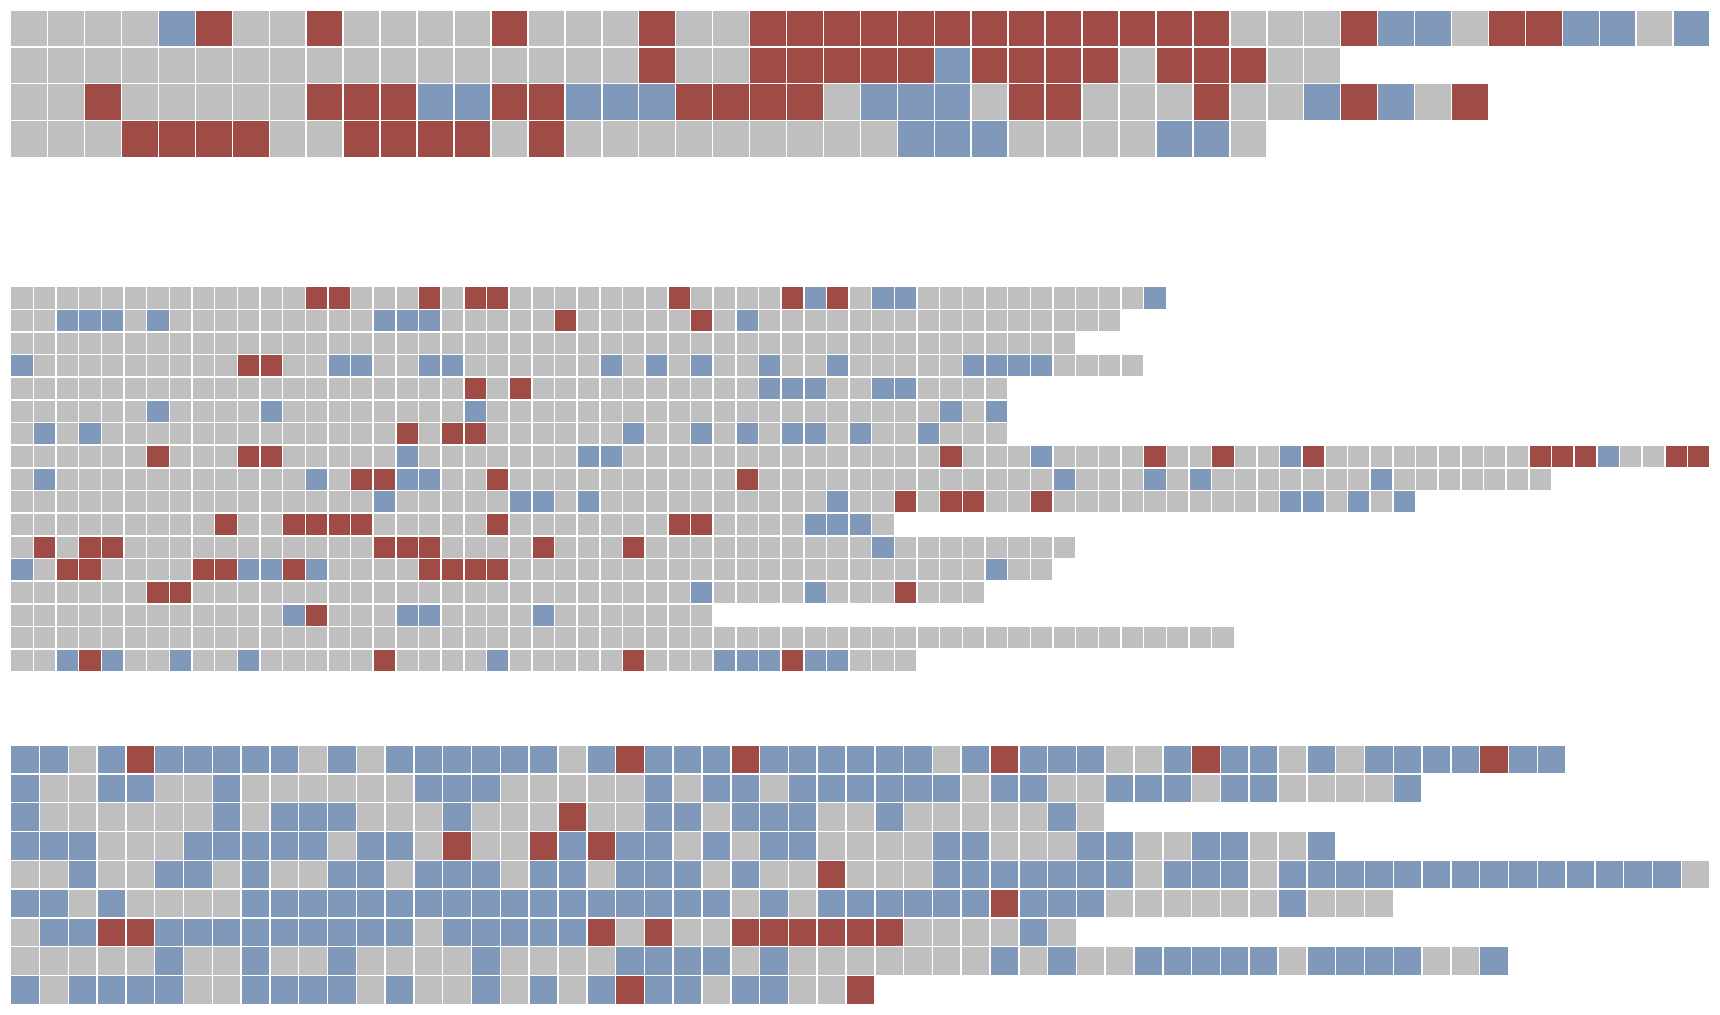

In [23]:
if cluster_all:
    # plotting all clusters thermal
    df_merged_clusters_sorted = df_merged_clusters.sort_values(by=['prefer_cooler'], ascending=False)
    comfort = "thermal"

    figure, axes = plt.subplots(3, 1, figsize=(24, 17))

    for ax, big_cluster in zip(axes.flatten(), [9, 10, 11]):
        print(big_cluster)
        plot_heatmap_tiles(df_merged_clusters_sorted[df_merged_clusters_sorted['big_cluster-thermal_cluster'] == big_cluster], 
                           ax, 
                           comfort=comfort, 
                           series_limit=75)

    figure.tight_layout()
    figure.savefig("hetmap_series_" + comfort + ".pdf", bbox_inches='tight')

else:
    df_merged_clusters_sorted = df_merged_clusters.sort_values(by=['prefer_cooler_x'], ascending=False)
    comfort = "thermal"
    
    figure, axes = plt.subplots(3, 1, figsize=(24, 17))

    for ax, big_cluster in zip(axes.flatten(), [0, 2, 1]):
        print(big_cluster)
        plot_heatmap_tiles(df_merged_clusters_sorted[df_merged_clusters_sorted['thermal_cluster'] == big_cluster], 
                           ax, 
                           comfort=comfort, 
                           series_limit=75)

    figure.tight_layout()
    figure.savefig("hetmap_series_" + comfort + ".pdf", bbox_inches='tight')
    

## Visual series

1
0
2


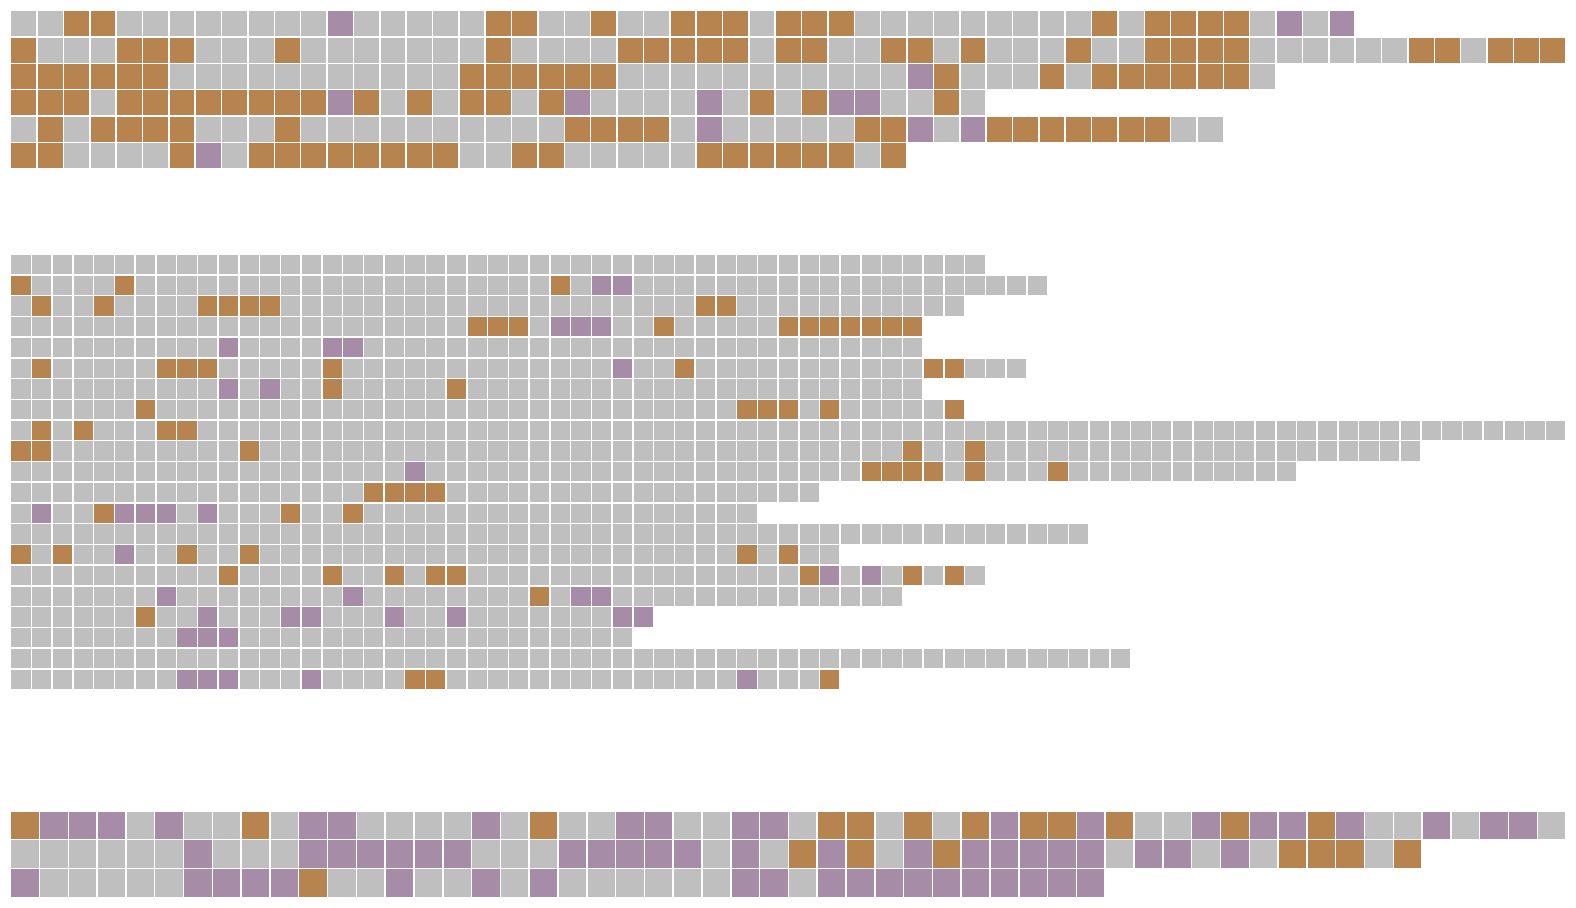

In [24]:
if cluster_all:
    # plotting all clusters visual
    df_merged_clusters_sorted = df_merged_clusters.sort_values(by=['prefer_dimmer'], ascending=False)
    comfort = "visual"

    figure, axes = plt.subplots(3, 1, figsize=(23, 17))

    for ax, big_cluster in zip(axes.flatten(), [9, 10, 11]):
        print(big_cluster)
        plot_heatmap_tiles(df_merged_clusters_sorted[df_merged_clusters_sorted['big_cluster-thermal'] == big_cluster], 
                           ax, 
                           comfort=comfort, 
                           series_limit=75)

    figure.tight_layout()
    figure.savefig("hetmap_series_" + comfort + ".pdf", bbox_inches='tight')
else:
    # plotting all clusters visual
    df_merged_clusters_sorted = df_merged_clusters.sort_values(by=['prefer_dimmer'], ascending=False)
    comfort = "visual"

    figure, axes = plt.subplots(3, 1, figsize=(22, 17))

    for ax, big_cluster in zip(axes.flatten(), [1, 0, 2]):
        print(big_cluster)
        plot_heatmap_tiles(df_merged_clusters_sorted[df_merged_clusters_sorted['light_cluster'] == big_cluster], 
                           ax, 
                           comfort=comfort, 
                           series_limit=75)

    figure.tight_layout()
    figure.savefig("hetmap_series_" + comfort + ".pdf", bbox_inches='tight')
    
    

## Aural series

0
1


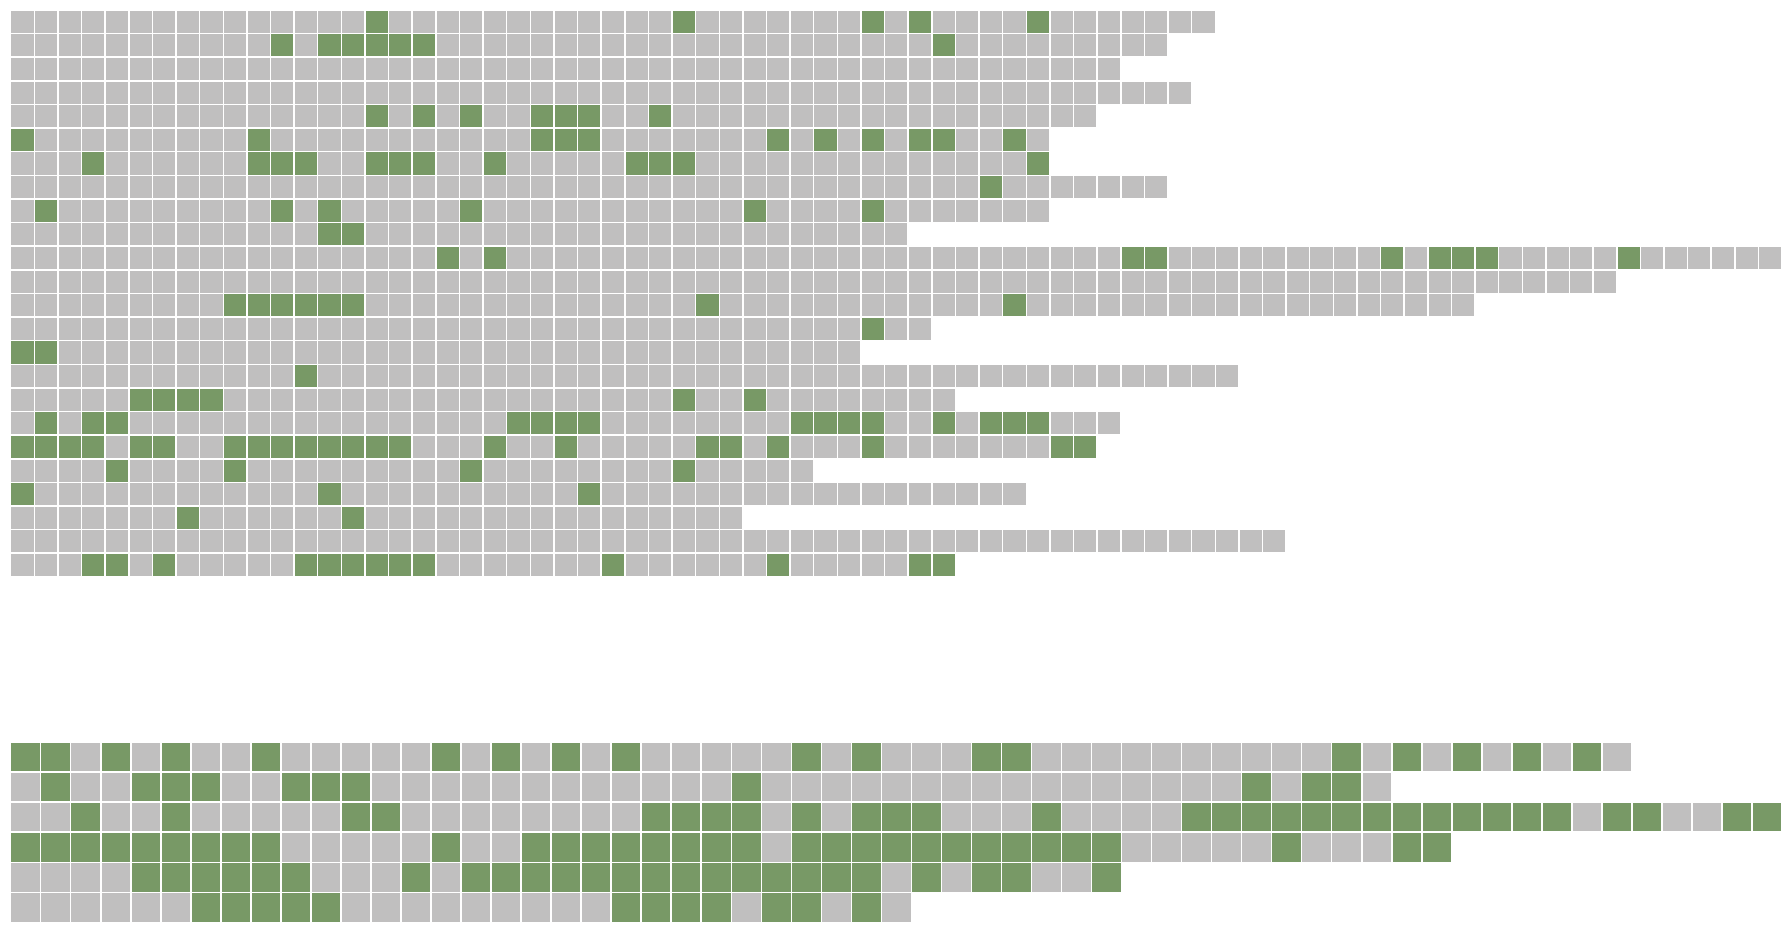

In [25]:
if cluster_all:
    # plotting all clusters aural
    df_merged_clusters_sorted = df_merged_clusters.sort_values(by=['prefer_quieter'], ascending=False)
    comfort = "aural"

    figure, axes = plt.subplots(2, 1, figsize=(25, 17))

    for ax, big_cluster in zip(axes.flatten(), [10, 11]):
        print(big_cluster)
        plot_heatmap_tiles(df_merged_clusters_sorted[df_merged_clusters_sorted['big_cluster-thermal'] == big_cluster], 
                           ax, 
                           comfort=comfort, 
                           series_limit=75)

    figure.tight_layout()
    figure.savefig("hetmap_series_" + comfort + ".pdf", bbox_inches='tight')

else:
    # plotting all clusters aural
    df_merged_clusters_sorted = df_merged_clusters.sort_values(by=['prefer_quieter'], ascending=False)
    comfort = "aural"

    figure, axes = plt.subplots(2, 1, figsize=(25, 17))

    for ax, big_cluster in zip(axes.flatten(), [0, 1]):
        print(big_cluster)
        plot_heatmap_tiles(df_merged_clusters_sorted[df_merged_clusters_sorted['aural_cluster'] == big_cluster], 
                           ax, 
                           comfort=comfort, 
                           series_limit=75)

    figure.tight_layout()
    figure.savefig("hetmap_series_" + comfort + ".pdf", bbox_inches='tight')
